### Предметная область: Игра Dota 2

[Dota 2](https://ru.wikipedia.org/wiki/Dota_2) — многопользовательская компьютерная игра жанра [MOBA](https://ru.wikipedia.org/wiki/MOBA). Игроки играют между собой матчи. В каждом матче участвует две команды, 5 человек в каждой. Одна команда играет за светлую сторону (The Radiant), другая — за тёмную (The Dire). Цель каждой команды — уничтожить главное здание базы противника (трон).


#### 1. Игроки выбирают героев

Всего в игре чуть более 100 различных героев (персонажей). В начале игры, команды в определенном порядке выбирают героев себе и запрещают выбирать определенных героев противнику (баны). Каждый игрок будет управлять одним героем, в рамках одного матча не может быть несколько одинаковых героев.  Герои различаются между собой своими характеристиками и способностями. От комбинации выбранных героев во многом зависит успех команды.


#### 2. Основная часть

Игроки могут получать золото и опыт за убийство чужих героев или прочих юнитов. Накопленный опыт влияет на уровень героя, который в свою очередь позволяет улучшать способности. За накопленное золото игроки покупают предметы, которые улучшают характеристики героев или дают им новые способности.

После смерти герой отправляется в "таверну" и возрождается только по прошествии некоторого времени, таким образом команда на некоторое время теряет игрока, однако игрок может досрочно выкупить героя из таверны за определенную сумму золота.

В течение игры команды развивают своих героев, обороняют свою часть поля и нападают на вражескую.


#### 3. Конец игры

Игра заканчивается, когда одна из команд разрушет определенное число "башен" противника и уничтожает трон.



### Задача: предсказание победы по данным о первых 5 минутах игры

По первым 5 минутам игры предсказать, какая из команд победит: Radiant или Dire?

#### Описание признаков в таблице

- `match_id`: идентификатор матча в наборе данных
- `start_time`: время начала матча (unixtime)
- `lobby_type`: тип комнаты, в которой собираются игроки (расшифровка в `dictionaries/lobbies.csv`)
- Наборы признаков для каждого игрока (игроки команды Radiant — префикс `rN`, Dire — `dN`):
    - `r1_hero`: герой игрока (расшифровка в dictionaries/heroes.csv)
    - `r1_level`: максимальный достигнутый уровень героя (за первые 5 игровых минут)
    - `r1_xp`: максимальный полученный опыт
    - `r1_gold`: достигнутая ценность героя
    - `r1_lh`: число убитых юнитов
    - `r1_kills`: число убитых игроков
    - `r1_deaths`: число смертей героя
    - `r1_items`: число купленных предметов
- Признаки события "первая кровь" (first blood). Если событие "первая кровь" не успело произойти за первые 5 минут, то признаки принимают пропущенное значение
    - `first_blood_time`: игровое время первой крови
    - `first_blood_team`: команда, совершившая первую кровь (0 — Radiant, 1 — Dire)
    - `first_blood_player1`: игрок, причастный к событию
    - `first_blood_player2`: второй игрок, причастный к событию
- Признаки для каждой команды (префиксы `radiant_` и `dire_`)
    - `radiant_bottle_time`: время первого приобретения командой предмета "bottle"
    - `radiant_courier_time`: время приобретения предмета "courier" 
    - `radiant_flying_courier_time`: время приобретения предмета "flying_courier" 
    - `radiant_tpscroll_count`: число предметов "tpscroll" за первые 5 минут
    - `radiant_boots_count`: число предметов "boots"
    - `radiant_ward_observer_count`: число предметов "ward_observer"
    - `radiant_ward_sentry_count`: число предметов "ward_sentry"
    - `radiant_first_ward_time`: время установки командой первого "наблюдателя", т.е. предмета, который позволяет видеть часть игрового поля
- Итог матча (данные поля отсутствуют в тестовой выборке, поскольку содержат информацию, выходящую за пределы первых 5 минут матча)
    - `duration`: длительность
    - `radiant_win`: 1, если победила команда Radiant, 0 — иначе
    - Состояние башен и барраков к концу матча (см. описание полей набора данных)
        - `tower_status_radiant`
        - `tower_status_dire`
        - `barracks_status_radiant`
        - `barracks_status_dire`

In [47]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import math
import time
import datetime
%matplotlib inline

In [48]:
from google.colab import drive
drive.mount('/data')

Drive already mounted at /data; to attempt to forcibly remount, call drive.mount("/data", force_remount=True).


In [49]:
!ls "/data/MyDrive"

'Colab Notebooks'   features_test.csv	  kurs_labs
 features.csv	    final_statement.csv


#### Чтение файла с признаками

In [50]:
features = pd.read_csv('/data/MyDrive/features.csv', index_col='match_id')
objects_count = features.shape[0]
print("features.shape: ", features.shape)
features.head()

features.shape:  (97230, 108)


,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,r2_hero,r2_level,r2_xp,r2_gold,r2_lh,r2_kills,r2_deaths,r2_items,r3_hero,r3_level,r3_xp,r3_gold,r3_lh,r3_kills,r3_deaths,r3_items,r4_hero,r4_level,r4_xp,r4_gold,r4_lh,r4_kills,r4_deaths,r4_items,r5_hero,r5_level,r5_xp,r5_gold,r5_lh,r5_kills,...,d4_xp,d4_gold,d4_lh,d4_kills,d4_deaths,d4_items,d5_hero,d5_level,d5_xp,d5_gold,d5_lh,d5_kills,d5_deaths,d5_items,first_blood_time,first_blood_team,first_blood_player1,first_blood_player2,radiant_bottle_time,radiant_courier_time,radiant_flying_courier_time,radiant_tpscroll_count,radiant_boots_count,radiant_ward_observer_count,radiant_ward_sentry_count,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
match_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,67,3,842,991,10,0,0,4,29,5,1909,1143,10,0,0,8,20,3,757,741,6,0,0,7,105,3,732,658,4,0,...,742,500,2,0,0,8,84,3,958,1003,3,1,0,9,7.0,1.0,9.0,NaN,134.0,-80.0,244.0,2,2,2,0,35.0,103.0,-84.0,221.0,3,4,2,2,-52.0,2874,1,1796,0,51,0
1,1430220345,0,42,4,1188,1033,9,0,1,12,49,4,1596,993,10,0,1,7,67,4,1506,1502,18,1,0,7,37,3,669,631,7,0,0,7,26,2,415,539,1,0,...,440,583,0,0,0,7,12,4,1470,1622,24,0,0,9,54.0,1.0,7.0,NaN,173.0,-80.0,NaN,2,0,2,0,-20.0,149.0,-84.0,195.0,5,4,3,1,-5.0,2463,1,1974,0,63,1
2,1430227081,7,33,4,1319,1270,22,0,0,12,98,3,1314,775,6,0,0,6,20,3,1297,909,0,1,0,6,27,5,2360,2096,26,1,1,6,4,3,1395,1627,27,0,...,1319,667,4,0,0,7,80,3,1350,1512,25,0,0,7,224.0,0.0,3.0,NaN,63.0,-82.0,NaN,2,5,2,1,-39.0,45.0,-77.0,221.0,3,4,3,1,13.0,2130,0,0,1830,0,63
3,1430263531,1,29,4,1779,1056,14,0,0,5,30,2,539,539,1,0,0,6,75,5,2037,1139,15,0,0,6,37,2,591,499,0,0,0,6,41,3,712,1075,12,0,...,674,537,1,0,0,7,20,2,510,499,0,0,0,7,NaN,NaN,NaN,NaN,208.0,-75.0,NaN,0,3,2,0,-30.0,124.0,-80.0,184.0,0,4,2,0,27.0,1459,0,1920,2047,50,63
4,1430282290,7,13,4,1431,1090,8,1,0,8,27,2,629,552,0,0,1,7,30,3,884,927,0,1,0,8,72,3,925,1439,16,1,0,11,93,4,1482,880,7,0,...,1815,1275,18,0,0,8,8,4,1119,904,6,0,1,7,-21.0,1.0,6.0,NaN,166.0,-81.0,181.0,1,4,2,0,46.0,182.0,-80.0,225.0,6,3,3,0,-16.0,2449,0,4,1974,3,63


#### Обработка исходных данных

Удаление признаков, связанных с итогами матча (они помечены в описании данных как отсутствующие в тестовой выборке).
    
- `duration`: длительность
- `radiant_win`: 1, если победила команда Radiant, 0 — иначе
- Состояние башен и барраков к концу матча (см. описание полей набора данных)
    - `tower_status_radiant`
    - `tower_status_dire`
    - `barracks_status_radiant`
    - `barracks_status_dire`

In [51]:
X_train = features.drop(['start_time', 'duration', 'radiant_win', 'tower_status_radiant', 
                          'tower_status_dire', 'barracks_status_radiant', 'barracks_status_dire'], axis = 1)
X_train_ver2 = X_train.copy()

features_count = X_train.shape[1]

y_train = features['radiant_win'].astype('int32')
#y_train = features['radiant_win']

print("X_train.shape: ", X_train.shape)
print("y_train.shape: ", y_train.shape)
X_train.head()

X_train.shape:  (97230, 101)
y_train.shape:  (97230,)


,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,r2_hero,r2_level,r2_xp,r2_gold,r2_lh,r2_kills,r2_deaths,r2_items,r3_hero,r3_level,r3_xp,r3_gold,r3_lh,r3_kills,r3_deaths,r3_items,r4_hero,r4_level,r4_xp,r4_gold,r4_lh,r4_kills,r4_deaths,r4_items,r5_hero,r5_level,r5_xp,r5_gold,r5_lh,r5_kills,r5_deaths,...,d3_lh,d3_kills,d3_deaths,d3_items,d4_hero,d4_level,d4_xp,d4_gold,d4_lh,d4_kills,d4_deaths,d4_items,d5_hero,d5_level,d5_xp,d5_gold,d5_lh,d5_kills,d5_deaths,d5_items,first_blood_time,first_blood_team,first_blood_player1,first_blood_player2,radiant_bottle_time,radiant_courier_time,radiant_flying_courier_time,radiant_tpscroll_count,radiant_boots_count,radiant_ward_observer_count,radiant_ward_sentry_count,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time
match_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,7,11,5,2098,1489,20,0,0,7,67,3,842,991,10,0,0,4,29,5,1909,1143,10,0,0,8,20,3,757,741,6,0,0,7,105,3,732,658,4,0,1,...,23,0,0,6,37,3,742,500,2,0,0,8,84,3,958,1003,3,1,0,9,7.0,1.0,9.0,NaN,134.0,-80.0,244.0,2,2,2,0,35.0,103.0,-84.0,221.0,3,4,2,2,-52.0
1,0,42,4,1188,1033,9,0,1,12,49,4,1596,993,10,0,1,7,67,4,1506,1502,18,1,0,7,37,3,669,631,7,0,0,7,26,2,415,539,1,0,0,...,2,2,0,12,7,2,440,583,0,0,0,7,12,4,1470,1622,24,0,0,9,54.0,1.0,7.0,NaN,173.0,-80.0,NaN,2,0,2,0,-20.0,149.0,-84.0,195.0,5,4,3,1,-5.0
2,7,33,4,1319,1270,22,0,0,12,98,3,1314,775,6,0,0,6,20,3,1297,909,0,1,0,6,27,5,2360,2096,26,1,1,6,4,3,1395,1627,27,0,0,...,3,0,0,8,29,4,1319,667,4,0,0,7,80,3,1350,1512,25,0,0,7,224.0,0.0,3.0,NaN,63.0,-82.0,NaN,2,5,2,1,-39.0,45.0,-77.0,221.0,3,4,3,1,13.0
3,1,29,4,1779,1056,14,0,0,5,30,2,539,539,1,0,0,6,75,5,2037,1139,15,0,0,6,37,2,591,499,0,0,0,6,41,3,712,1075,12,0,0,...,11,0,0,7,102,2,674,537,1,0,0,7,20,2,510,499,0,0,0,7,NaN,NaN,NaN,NaN,208.0,-75.0,NaN,0,3,2,0,-30.0,124.0,-80.0,184.0,0,4,2,0,27.0
4,7,13,4,1431,1090,8,1,0,8,27,2,629,552,0,0,1,7,30,3,884,927,0,1,0,8,72,3,925,1439,16,1,0,11,93,4,1482,880,7,0,0,...,1,0,0,9,25,5,1815,1275,18,0,0,8,8,4,1119,904,6,0,1,7,-21.0,1.0,6.0,NaN,166.0,-81.0,181.0,1,4,2,0,46.0,182.0,-80.0,225.0,6,3,3,0,-16.0


Проверьте выборку на наличие пропусков с помощью функции count(), которая для каждого столбца показывает число заполненных значений. Много ли пропусков в данных? Запишите названия признаков, имеющих пропуски, и попробуйте для любых двух из них дать обоснование, почему их значения могут быть пропущены.

In [52]:
cnt = pd.DataFrame(X_train.count(), columns=['Count'])
cnt[cnt['Count'] < objects_count]

,Count
first_blood_time,77677
first_blood_team,77677
first_blood_player1,77677
first_blood_player2,53243
radiant_bottle_time,81539
radiant_courier_time,96538
radiant_flying_courier_time,69751
radiant_first_ward_time,95394
dire_bottle_time,81087
dire_courier_time,96554


Признаки, имеющие пропуски среди своих значений:

    - `first_blood_time`: игровое время первой крови
    - `first_blood_team`: команда, совершившая первую кровь (0 — Radiant, 1 — Dire)
    - `first_blood_player1`: игрок, причастный к событию
    - `first_blood_player2`: второй игрок, причастный к событию
- Признаки для каждой команды (префиксы `radiant_` и `dire_`)
    - `radiant_bottle_time`: время первого приобретения командой предмета "bottle"
    - `radiant_courier_time`: время приобретения предмета "courier" 
    - `radiant_flying_courier_time`: время приобретения предмета "flying_courier" 
    - `radiant_first_ward_time`: время установки командой первого "наблюдателя", т.е. предмета, который позволяет видеть часть игрового поля

Причина пропущенных значений - соответствующие события не успели произойти за первые 5 минут. Например не было события "первая кровь" или никто из игроков не приобрёл соответствующий артифакт.

### Подход 1: градиентный бустинг "в лоб"
Один из самых универсальных алгоритмов, изученных в нашем курсе, является градиентный бустинг. Он не очень требователен к данным, восстанавливает нелинейные зависимости, и хорошо работает на многих наборах данных, что и обуславливает его популярность. Вполне разумной мыслью будет попробовать именно его в первую очередь.

1. **DONE**: Считайте таблицу с признаками из файла features.csv с помощью кода, приведенного выше. Удалите признаки, связанные с итогами матча (они помечены в описании данных как отсутствующие в тестовой выборке).
2. **DONE**: Проверьте выборку на наличие пропусков с помощью функции count(), которая для каждого столбца показывает число заполненных значений. Много ли пропусков в данных? Запишите названия признаков, имеющих пропуски, и попробуйте для любых двух из них дать обоснование, почему их значения могут быть пропущены.
3. **DONE**: Замените пропуски на нули с помощью функции fillna(). На самом деле этот способ является предпочтительным для логистической регрессии, поскольку он позволит пропущенному значению не вносить никакого вклада в предсказание. Для деревьев часто лучшим вариантом оказывается замена пропуска на очень большое или очень маленькое значение — в этом случае при построении разбиения вершины можно будет отправить объекты с пропусками в отдельную ветвь дерева. Также есть и другие подходы — например, замена пропуска на среднее значение признака. Мы не требуем этого в задании, но при желании попробуйте разные подходы к обработке пропусков и сравните их между собой.
3. **DONE**: Какой столбец содержит целевую переменную? Запишите его название.
4. **DONE**: Забудем, что в выборке есть категориальные признаки, и попробуем обучить градиентный бустинг над деревьями на имеющейся матрице "объекты-признаки". Зафиксируйте генератор разбиений для кросс-валидации по 5 блокам (KFold), не забудьте перемешать при этом выборку (shuffle=True), поскольку данные в таблице отсортированы по времени, и без перемешивания можно столкнуться с нежелательными эффектами при оценивании качества. Оцените качество градиентного бустинга (GradientBoostingClassifier) с помощью данной кросс-валидации, попробуйте при этом разное количество деревьев (как минимум протестируйте следующие значения для количества деревьев: 10, 20, 30). Долго ли настраивались классификаторы? Достигнут ли оптимум на испытанных значениях параметра n_estimators, или же качество, скорее всего, продолжит расти при дальнейшем его увеличении?

##### Что указать в отчете
В отчете по данному этапу вы должны ответить на следующие вопросы:
1. Какие признаки имеют пропуски среди своих значений? Что могут означать пропуски в этих признаках (ответьте на этот вопрос для двух любых признаков)?
2. Как называется столбец, содержащий целевую переменную?
3. Как долго проводилась кросс-валидация для градиентного бустинга с 30 деревьями? Какое качество при этом получилось? Напомним, что в данном задании мы используем метрику качества AUC-ROC.
4. Имеет ли смысл использовать больше 30 деревьев в градиентном бустинге? Что бы вы предложили делать, чтобы ускорить его обучение при увеличении количества деревьев?

Замените пропуски на нули с помощью функции fillna(). На самом деле этот способ является предпочтительным для логистической регрессии, поскольку он позволит пропущенному значению не вносить никакого вклада в предсказание. Для деревьев часто лучшим вариантом оказывается замена пропуска на очень большое или очень маленькое значение — в этом случае при построении разбиения вершины можно будет отправить объекты с пропусками в отдельную ветвь дерева. 

Также есть и другие подходы — например, замена пропуска на среднее значение признака. Мы не требуем этого в задании, но при желании попробуйте разные подходы к обработке пропусков и сравните их между собой.

In [53]:
X_train.fillna(0, inplace=True)

In [54]:
fields_with_na = cnt[cnt['Count'] < objects_count].index
for field in fields_with_na:
    X_train_ver2[field].fillna(X_train_ver2[field].mean(), inplace=True)

Столбец, содержащий целевую переменную называется **radiant_win**

Забудем, что в выборке есть категориальные признаки, и попробуем обучить градиентный бустинг над деревьями на имеющейся матрице "объекты-признаки". 

Зафиксируйте генератор разбиений для кросс-валидации по 5 блокам (KFold), не забудьте перемешать при этом выборку (shuffle=True), поскольку данные в таблице отсортированы по времени, и без перемешивания можно столкнуться с нежелательными эффектами при оценивании качества. 

Оцените качество градиентного бустинга (GradientBoostingClassifier) с помощью данной кросс-валидации, попробуйте при этом разное количество деревьев (как минимум протестируйте следующие значения для количества деревьев: 10, 20, 30). 

Долго ли настраивались классификаторы? 

Достигнут ли оптимум на испытанных значениях параметра n_estimators, или же качество, скорее всего, продолжит расти при дальнейшем его увеличении?

### Метрика качества

В качестве метрики качества мы будем использовать площадь под ROC-кривой (AUC-ROC). Обратите внимание, что AUC-ROC — это метрика качества для алгоритма, выдающего оценки принадлежности первому классу. Оба алгоритма, которые будут использоваться в проекте — градиентный бустинг, и логистическая регрессия — умеют выдавать такие оценки. Для этого нужно получать предсказания с помощью функции predict_proba. Она возвращает два столбца: первый содержит оценки принадлежности нулевому классу, второй — первому классу. Вам нужны значения из второго столбца:
```python
pred = clf.predict_proba(X_test)[:, 1]
```

In [55]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [57]:
d1 = []
for lr in [0.2, 0.3, 0.4]:
    for n_trees in [10, 30, 50, 70, 100]:
        start_time = datetime.datetime.now()
        clf = GradientBoostingClassifier(n_estimators=n_trees, random_state=42, learning_rate=lr)
        sc = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=kf, scoring='roc_auc').mean()   
        d1.append([lr, n_trees, sc, datetime.datetime.now() - start_time])
        print(lr, n_trees, sc, datetime.datetime.now() - start_time)

0.2 10 0.6771099027716354 0:00:42.347542
0.2 30 0.6981143173408741 0:02:08.882985
0.2 50 0.7046988217922763 0:03:32.448162
0.2 70 0.7082231922050335 0:04:59.659595
0.2 100 0.7122254548856686 0:07:12.198740
0.3 10 0.683596746653852 0:00:42.784355
0.3 30 0.7013327951410113 0:02:08.381096
0.3 50 0.7073475200647837 0:03:36.737226
0.3 70 0.7110244031519727 0:04:59.430078
0.3 100 0.7143492434543918 0:07:17.291056
0.4 10 0.6848478336673425 0:00:43.413403
0.4 30 0.7018184893831665 0:02:11.198137
0.4 50 0.7077838306272912 0:03:38.987250
0.4 70 0.7107030740469356 0:05:03.445029
0.4 100 0.7131506225040771 0:07:20.628625


In [58]:
d1_df = pd.DataFrame(d1, columns=['learning_rate', 'n_trees', 'cross_val_score', 'time_elapsed'])
print(d1_df.cross_val_score.max())
d1_df.pivot_table(index=['learning_rate', 'n_trees'])

0.7143492434543918


cross_val_score
learning_rate n_trees                 
0.2           10              0.677110
              30              0.698114
              50              0.704699
              70              0.708223
              100             0.712225
0.3           10              0.683597
              30              0.701333
              50              0.707348
              70              0.711024
              100             0.714349
0.4           10              0.684848
              30              0.701818
              50              0.707784
              70              0.710703
              100             0.713151

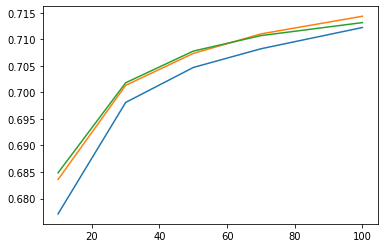

In [59]:
for lr in d1_df.learning_rate.unique():
    plt.plot(d1_df[d1_df.learning_rate == lr].n_trees, d1_df[d1_df.learning_rate == lr].cross_val_score)

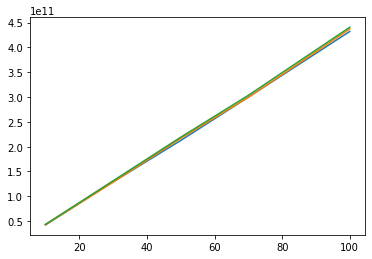

In [60]:
for lr in d1_df.learning_rate.unique():
    plt.plot(d1_df[d1_df.learning_rate == lr].n_trees, d1_df[d1_df.learning_rate == lr].time_elapsed)

Также есть и другие подходы — например, замена пропуска на среднее значение признака. Мы не требуем этого в задании, но при желании попробуйте разные подходы к обработке пропусков и сравните их между собой.

In [61]:
start_time = datetime.datetime.now()
clf = GradientBoostingClassifier(n_estimators=100, random_state=42, learning_rate=0.3)
sc = cross_val_score(estimator=clf, X=X_train_ver2, y=y_train, cv=kf, scoring='roc_auc').mean()   
print(sc, datetime.datetime.now() - start_time)

0.7133375067413577 0:07:13.573144


Кросс-валидация для градиентного бустинга с 30 деревьями заняла 2 мин, результат 0,701

Оптимум не достигается, качество продолжает расти вплоть до значения параметра n_estimators = 100.
**Длительность** обучения классификатора **растёт линейно с увеличением параметра n_estimators**.

**В итоге** при n_estimators=100 и learning_rate=0.3 расчёт занял 7 мин (на Google Colab) и качество составило **0.714** 

Замена пропуска на среднее значение признака увеличение качества не дала. Качество даже упало = 0.713

Далее будет показано, что значительного увеличения быстродействия без ущерба качеству можно достичь переходом на использование алгоритма XGBoost.

### Подход 2: логистическая регрессия

Линейные методы работают гораздо быстрее композиций деревьев, поэтому кажется разумным воспользоваться именно ими для ускорения анализа данных. Одним из наиболее распространенных методов для классификации является логистическая регрессия.

**Важно:** не забывайте, что линейные алгоритмы чувствительны к масштабу признаков! Может пригодиться sklearn.preprocessing.StandartScaler.

1. **DONE** Оцените качество логистической регрессии (sklearn.linear_model.LogisticRegression с L2-регуляризацией) с помощью кросс-валидации по той же схеме, которая использовалась для градиентного бустинга. Подберите при этом лучший параметр регуляризации (C). Какое наилучшее качество у вас получилось? Как оно соотносится с качеством градиентного бустинга? Чем вы можете объяснить эту разницу? Быстрее ли работает логистическая регрессия по сравнению с градиентным бустингом?
2. **DONE** Среди признаков в выборке есть категориальные, которые мы использовали как числовые, что вряд ли является хорошей идеей. Категориальных признаков в этой задаче одиннадцать: lobby_type и r1_hero, r2_hero, ..., r5_hero, d1_hero, d2_hero, ..., d5_hero. Уберите их из выборки, и проведите кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации. Изменилось ли качество? Чем вы можете это объяснить?
3. **DONE** На предыдущем шаге мы исключили из выборки признаки rM_hero и dM_hero, которые показывают, какие именно герои играли за каждую команду. Это важные признаки — герои имеют разные характеристики, и некоторые из них выигрывают чаще, чем другие. Выясните из данных, сколько различных идентификаторов героев существует в данной игре (вам может пригодиться фукнция unique или value_counts).
4. **DONE** Воспользуемся подходом "мешок слов" для кодирования информации о героях. Пусть всего в игре имеет N различных героев. Сформируем N признаков, при этом i-й будет равен нулю, если i-й герой не участвовал в матче; единице, если i-й герой играл за команду Radiant; минус единице, если i-й герой играл за команду Dire. Ниже вы можете найти код, который выполняет данной преобразование. Добавьте полученные признаки к числовым, которые вы использовали во втором пункте данного этапа.
5. **DONE** Проведите кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации. Какое получилось качество? Улучшилось ли оно? Чем вы можете это объяснить?
6. **DONE** Постройте предсказания вероятностей победы команды Radiant для тестовой выборки с помощью лучшей из изученных моделей (лучшей с точки зрения AUC-ROC на кросс-валидации). Убедитесь, что предсказанные вероятности адекватные — находятся на отрезке [0, 1], не совпадают между собой (т.е. что модель не получилась константной).

##### Что указать в отчете
В отчете по данному этапу вы должны ответить на следующие вопросы:
1. Какое качество получилось у логистической регрессии над всеми исходными признаками? Как оно соотносится с качеством градиентного бустинга? Чем вы можете объяснить эту разницу? Быстрее ли работает логистическая регрессия по сравнению с градиентным бустингом?
2. Как влияет на качество логистической регрессии удаление категориальных признаков (укажите новое значение метрики качества)? Чем вы можете объяснить это изменение?
3. Сколько различных идентификаторов героев существует в данной игре?
4. Какое получилось качество при добавлении "мешка слов" по героям? Улучшилось ли оно по сравнению с предыдущим вариантом? Чем вы можете это объяснить?
5. Какое минимальное и максимальное значение прогноза на тестовой выборке получилось у лучшего из алгоритмов?

In [62]:
scaler = StandardScaler()

In [63]:
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train))
X_train_scaled

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
0,1.540688,-1.244228,1.400808,1.525972,0.734957,0.969743,-0.537757,-0.578083,-0.509023,0.453467,-0.332256,-0.625222,-0.255162,-0.052580,-0.533149,-0.582396,-1.756715,-0.728192,1.507230,1.308568,0.095346,-0.037204,-0.529081,-0.578154,-0.112095,-0.999319,-0.282744,-0.729830,-0.757388,-0.446505,-0.525343,-0.579877,-0.525183,1.606179,-0.277630,-0.771379,-0.935772,-0.669994,-0.524078,1.052453,...,1.416964,-0.538253,-0.571065,-0.947053,-0.490513,-0.311205,-0.785580,-1.312874,-0.905651,-0.53886,-0.567540,-0.131690,0.950987,-0.316231,-0.398260,-0.192406,-0.794164,0.976866,-0.565289,0.278256,-0.849902,1.182703,1.681514,-0.788219,0.378538,-0.029781,0.876751,-0.514555,-1.136970,-0.532046,-0.987486,1.066448,-0.041743,-0.262922,0.640648,0.018054,0.562864,-0.551154,1.846004,-1.121494
1,-0.927798,-0.292258,0.501314,-0.080139,-0.247570,-0.246859,-0.537757,1.017574,1.492930,-0.097431,0.578881,0.732454,-0.250795,-0.052580,-0.533149,1.019572,-0.524101,0.438857,0.591580,0.582307,0.884835,0.856569,1.014674,-0.578154,-0.521910,-0.478969,-0.282744,-0.889558,-1.001642,-0.334372,-0.525343,-0.579877,-0.525183,-0.816535,-1.190175,-1.344598,-1.198371,-1.005251,-0.524078,-0.573665,...,-0.942193,2.506742,-0.571065,1.517711,-1.414707,-1.232681,-1.337375,-1.127777,-1.131068,-0.53886,-0.567540,-0.543653,-1.262018,0.599652,0.531154,1.183531,1.570177,-0.540155,-0.565289,0.278256,-0.287631,1.182703,1.050584,-0.788219,0.912215,-0.029781,-1.525446,-0.514555,-2.869460,-0.532046,-0.987486,-0.338591,0.578946,-0.262922,0.379585,1.066668,0.562864,0.678170,0.437788,0.043947
2,1.540688,-0.568637,0.501314,0.151070,0.263085,1.190944,-0.537757,-0.578083,1.492930,1.402237,-0.332256,0.224676,-0.726779,-0.498410,-0.533149,-0.582396,-0.934972,-1.004599,-0.324070,0.205660,-0.419251,-1.154419,1.014674,-0.578154,-0.931725,-0.785057,1.547927,2.179771,2.251377,1.796163,1.030097,1.043031,-0.937075,-1.491215,-0.277630,0.427498,1.202532,1.900308,-0.524078,-0.573665,...,-0.829853,-0.538253,-0.571065,-0.125465,-0.736965,0.610270,0.268676,-0.940451,-0.680234,-0.53886,-0.567540,-0.543653,0.828042,-0.316231,0.313323,0.939019,1.682765,-0.540155,-0.565289,-0.543829,1.746117,-0.845521,-0.211277,-0.788219,-0.593027,-0.146503,-1.525446,-0.514555,1.461765,-0.532046,0.391203,-0.823968,-0.824352,0.158654,0.640648,0.018054,0.562864,0.678170,0.437788,0.490286
3,-0.575157,-0.691471,0.501314,0.962950,-0.198013,0.306142,-0.537757,-0.578083,-1.309804,-0.678935,-1.243393,-1.170813,-1.242065,-1.055698,-0.533149,-0.582396,-0.934972,0.684551,1.507230,1.539241,0.086550,0.521404,-0.529081,-0.578154,-0.931725,-0.478969,-1.198079,-1.031136,-1.294746,-1.119305,-0.525343,-0.579877,-0.937075,-0.356526,-0.277630,-0.807544,-0.015573,0.224024,-0.524078,-0.573665,...,0.068874,-0.538253,-0.571065,-0.536259,1.511906,-1.232681,-0.909825,-1.230361,-1.018359,-0.53886,-0.567540,-0.543653,-1.016129,-1.232114,-1.211497,-1.312717,-1.131927,-0.540155,-0.565289,-0.543829,-0.933645,-0.845521,-1.157673,-0.788219,1.391156,0.262024,-1.525446,-1.549070,-0.270725,-0.532046,-0.987486,-0.594053,0.241615,-0.022021,0.269135,-1.554868,0.562864,-0.551154,-0.970428,0.837439
4,1.540688,-1.182811,0.501314,0.348745,-0.124754,-0.357459,0.968527,-0.578083,-0.108632,-0.770751,-1.243393,-1.008757,-1.213680,-1.167155,-0.533149,1.019572,-0.524101,-0.697480,-0.324070,-0.538623,-0.379666,-1.154419,1.014674,-0.578154,-0.112095,0.592339,-0.282744,-0.424893,0.792515,0.674829,1.030097,-0.579877,1.122386,1.238171,0.634915,0.584817,-0.445882,-0.334737,-0.524078,-0.573665,...,-1.054534,-0.538253,-0.571065,0.285329,-0.860191,1.531746,1.174935,0.415438,0.897683,-0.53886,-0.567540,-0.131690,-1.384963,0.599652,-0.106003,-0.412467,-0.456401,-0.540155,1.085005,-0.543829,-1.184873,1.182703,0.735119,-0.788219,0.816427,-0.088142,0.256512

Оцените качество логистической регрессии (sklearn.linear_model.LogisticRegression с L2-регуляризацией) с помощью кросс-валидации по той же схеме, которая использовалась для градиентного бустинга. Подберите при этом лучший параметр регуляризации (C). Какое наилучшее качество у вас получилось? Как оно соотносится с качеством градиентного бустинга? Чем вы можете объяснить эту разницу? Быстрее ли работает логистическая регрессия по сравнению с градиентным бустингом?

In [65]:
clf = LogisticRegression(penalty='l2', random_state=42)
params = { 'C': np.logspace(*(-4, 2), num=100) }
gs = GridSearchCV(estimator=clf, param_grid=params, refit=True, scoring='roc_auc', n_jobs=-1, cv=kf, verbose=1)
gs.fit(X_train_scaled, y_train)
print(gs.best_params_)
print(gs.cv_results_['mean_test_score'][gs.best_index_])

Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'C': 0.004977023564332114}
0.7164432215604368


In [69]:
start_time = datetime.datetime.now()
clf = LogisticRegression(penalty='l2', C=0.005, random_state=42)
sc = cross_val_score(estimator=clf, X=X_train_scaled, y=y_train, cv=kf, scoring='roc_auc').mean()   
print(sc, datetime.datetime.now()-start_time)

0.716443056332629 0:00:06.052049


Как оно соотносится с качеством градиентного бустинга? **Чем вы можете объяснить эту разницу?** Быстрее ли работает логистическая регрессия по сравнению с градиентным бустингом?

Hаилучшее качество получилось =0.716 - что **сопоставимо с качеством градиентного бустинга**

Но время работы значительно меньше - всего 6 сек!!

Среди признаков в выборке есть категориальные, которые мы использовали как числовые, что вряд ли является хорошей идеей. Категориальных признаков в этой задаче одиннадцать: lobby_type и r1_hero, r2_hero, ..., r5_hero, d1_hero, d2_hero, ..., d5_hero. Уберите их из выборки, и проведите кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации. Изменилось ли качество? Чем вы можете это объяснить?

In [70]:
heroes_features = [f"{j}{i}_hero" for i in range(1, 6) for j in ['r', 'd']]
X_train_ver3 = X_train.drop(heroes_features + ['lobby_type'], axis = 1)
# X_train[heroes_features]

In [72]:
X_train_ver3_scaled = pd.DataFrame(scaler.fit_transform(X_train_ver3))

In [73]:
start_time = datetime.datetime.now()
clf = LogisticRegression(penalty='l2', C=0.005, random_state=42)
sc = cross_val_score(estimator=clf, X=X_train_ver3_scaled, y=y_train, cv=kf, scoring='roc_auc').mean()   
print(sc, datetime.datetime.now()-start_time)

0.7164508037469106 0:00:05.958382


В моём эксперименте после удаления категориальных признако качество логистической регрессии не изменилось - 0.716

На предыдущем шаге мы исключили из выборки признаки rM_hero и dM_hero, которые показывают, какие именно герои играли за каждую команду. Это важные признаки — герои имеют разные характеристики, и некоторые из них выигрывают чаще, чем другие. Выясните из данных, сколько различных идентификаторов героев существует в данной игре (вам может пригодиться фукнция unique или value_counts).

In [74]:
heroes = []
for col in heroes_features:
    heroes.extend(X_train[col].unique())
unique_heroes = np.unique(heroes)
N_heroes = len(unique_heroes)
print(heroes_features)
print(unique_heroes)
print(N_heroes)

['r1_hero', 'd1_hero', 'r2_hero', 'd2_hero', 'r3_hero', 'd3_hero', 'r4_hero', 'd4_hero', 'r5_hero', 'd5_hero']
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  25  26  27  28  29  30  31  32  33  34  35  36  37
  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55
  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 109 110 112]
108


Сколько различных идентификаторов героев существует в данной игре? **108**

Воспользуемся подходом "мешок слов" для кодирования информации о героях. Пусть всего в игре имеет N различных героев. Сформируем N признаков, при этом i-й будет равен нулю, если i-й герой не участвовал в матче; единице, если i-й герой играл за команду Radiant; минус единице, если i-й герой играл за команду Dire. Ниже вы можете найти код, который выполняет данное преобразование. Добавьте полученные признаки к числовым, которые вы использовали во втором пункте данного этапа.


##### Код для формирования "мешка слов" по героям
```python
# N — количество различных героев в выборке
X_pick = np.zeros((data.shape[0], N))

for i, match_id in enumerate(data.index):
    for p in xrange(5):
        X_pick[i, data.ix[match_id, 'r%d_hero' % (p + 1)] - 1] = 1
        X_pick[i, data.ix[match_id, 'd%d_hero' % (p + 1)] - 1] = -1
```

In [75]:
def VectorizeHeroes(X_data): 
  heroes_features = [f"{j}{i}_hero" for i in range(1, 6) for j in ['r', 'd']] 
  Max_hero = X_data[heroes_features].max().max()
  
  start_time = datetime.datetime.now()

  for h in range(1, Max_hero + 1):
    X_data[f'hero_{h}'] = 0
    X_data[f'hero_{h}'] = ((X_data[f'r{1}_hero'] == h) |
                           (X_data[f'r{2}_hero'] == h) |
                           (X_data[f'r{3}_hero'] == h) |
                           (X_data[f'r{4}_hero'] == h) |
                           (X_data[f'r{5}_hero'] == h)) * 1 + X_data[f'hero_{h}']
    X_data[f'hero_{h}'] = ((X_data[f'd{1}_hero'] == h) |
                           (X_data[f'd{2}_hero'] == h) |
                           (X_data[f'd{3}_hero'] == h) |
                           (X_data[f'd{4}_hero'] == h) |
                           (X_data[f'd{5}_hero'] == h)) * -1 + X_data[f'hero_{h}']
  
  print(datetime.datetime.now() - start_time)

  empty_columns = list(X_data.columns[X_data.std()==0])
  X_data = X_data.drop(empty_columns, axis = 1)
  
  X_data = X_data.drop(heroes_features + ['lobby_type'], axis = 1)  
  return X_data

In [76]:
X_train = VectorizeHeroes(X_train)

0:00:01.359027


Использование встроенных средств pandas на основе бинарной маски над столбцами работает быстрее, чем явный цикл по строкам. 1,5 сек по сравнению с 10 сек в случае цикла.

Проведите кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации. Какое получилось качество? Улучшилось ли оно? Чем вы можете это объяснить?

In [77]:
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train))

In [78]:
clf = LogisticRegression(penalty='l2', random_state=42)
params = { 'C': np.linspace(0.004, 0.006, num=50) }
gs = GridSearchCV(estimator=clf, param_grid=params, refit=True, scoring='roc_auc', n_jobs=-1, cv=kf, verbose=1)
gs.fit(X_train_scaled, y_train)
print(gs.best_params_)
print(gs.cv_results_['mean_test_score'][gs.best_index_])

Fitting 5 folds for each of 50 candidates, totalling 250 fits
{'C': 0.00526530612244898}
0.7518168655305381


In [79]:
C = 0.005265
start_time = datetime.datetime.now()
clf = LogisticRegression(penalty='l2', C=C, random_state=42)
sc = cross_val_score(estimator=clf, X=X_train_scaled, y=y_train, cv=kf, scoring='roc_auc').mean()   
print(sc, datetime.datetime.now() - start_time)

0.7518168358707273 0:00:09.796707


При добавлении "мешка слов" по героям качество **увеличилось до 0.752**. Это можно объяснить выделением факта участия каждого героя в игре в самостоятельный признак - повышении информативности признаков.

Уточнили еще раз C=0.005265, время расчёта 12 сек!

На данном этапе это лучший результат!

Постройте предсказания вероятностей победы команды Radiant для тестовой выборки с помощью лучшей из изученных моделей (лучшей с точки зрения AUC-ROC на кросс-валидации). Убедитесь, что предсказанные вероятности адекватные — находятся на отрезке [0, 1], не совпадают между собой (т.е. что модель не получилась константной).

### Проверка финальной модели

После того как вы провели все эксперименты и выбрали лучшую модель, можете проверить ее качество на тестовых матчах.  В отличие от основного набора матчей, в тестовых матчах есть только та информация, которая известна на момент первых 5 игровых минут, результат матча — неизвестен. Таблица признаков для тестовых матчей — `features_test.csv`.

Для всех матчей из тестового набора предскажите вероятность победы Radiant, запишите предсказания в CSV файл с колонками `match_id` (идентификатор матча) и `radiant_win` — предсказанная вероятность. Файл с предсказаниями должен выглядеть примерно следующим образом:

```
match_id,radiant_win
1,0.51997370502
4,0.51997370502
15,0.51997370502
...
```

Отправьте решение на Kaggle в соревнование: Dota 2: Win Probability Prediction.

Ссылка на соревнование: [Dota 2: Win Probability Prediction](https://kaggle.com/join/coursera_ml_dota2_contest)

In [80]:
features_test = pd.read_csv('/data/MyDrive/features_test.csv', index_col='match_id')
objects_test_count = features_test.shape[0]
print("features.shape: ", features_test.shape)
features_test.head()
X_test = features_test.drop(['start_time'], axis = 1)
features_test_count = X_test.shape[1]
print("X_test.shape: ", X_test.shape)
X_test.head()

features.shape:  (17177, 102)
X_test.shape:  (17177, 101)


,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,r2_hero,r2_level,r2_xp,r2_gold,r2_lh,r2_kills,r2_deaths,r2_items,r3_hero,r3_level,r3_xp,r3_gold,r3_lh,r3_kills,r3_deaths,r3_items,r4_hero,r4_level,r4_xp,r4_gold,r4_lh,r4_kills,r4_deaths,r4_items,r5_hero,r5_level,r5_xp,r5_gold,r5_lh,r5_kills,r5_deaths,...,d3_lh,d3_kills,d3_deaths,d3_items,d4_hero,d4_level,d4_xp,d4_gold,d4_lh,d4_kills,d4_deaths,d4_items,d5_hero,d5_level,d5_xp,d5_gold,d5_lh,d5_kills,d5_deaths,d5_items,first_blood_time,first_blood_team,first_blood_player1,first_blood_player2,radiant_bottle_time,radiant_courier_time,radiant_flying_courier_time,radiant_tpscroll_count,radiant_boots_count,radiant_ward_observer_count,radiant_ward_sentry_count,radiant_first_ward_time,dire_bottle_time,dire_courier_time,dire_flying_courier_time,dire_tpscroll_count,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time
match_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6,0,93,4,1103,1089,8,0,1,9,102,3,1183,963,9,0,2,9,52,5,2289,2043,20,2,0,6,53,3,917,1006,14,0,0,6,57,3,1344,933,3,0,0,...,2,1,0,9,29,3,1091,918,6,0,1,8,39,5,1674,1048,12,0,1,7,1.0,0.0,2.0,NaN,72.0,-82.0,NaN,2,2,3,0,12.0,247.0,-86.0,272.0,3,4,2,0,118.0
7,1,20,2,556,570,1,0,0,9,6,4,1194,1386,21,0,0,7,65,4,1374,1064,13,0,1,8,92,2,774,737,0,1,0,8,43,5,2254,1787,24,0,0,...,19,0,0,14,99,3,1075,718,3,0,1,7,5,4,1130,994,1,1,0,10,84.0,1.0,9.0,NaN,138.0,-82.0,233.0,2,6,2,2,-29.0,168.0,-54.0,NaN,3,2,2,1,16.0
10,1,112,2,751,808,1,0,0,13,26,2,421,569,3,0,0,6,29,3,960,896,3,1,2,6,11,5,1877,1511,23,0,0,8,41,4,1581,1593,26,0,0,...,12,0,0,8,49,5,2434,1917,22,0,0,9,54,4,1372,2005,24,2,1,11,168.0,1.0,9.0,NaN,33.0,-88.0,NaN,5,4,3,1,-22.0,46.0,-87.0,186.0,1,3,3,0,-34.0
13,1,27,3,708,903,1,1,1,11,91,2,672,901,6,0,0,8,74,5,2141,1626,28,0,0,7,52,4,1579,2169,28,2,0,7,2,5,1960,1668,27,0,0,...,22,0,0,7,62,2,536,692,0,1,1,6,49,4,1815,1424,18,0,0,5,55.0,0.0,3.0,NaN,208.0,-78.0,180.0,4,2,2,2,-49.0,30.0,-89.0,210.0,3,4,2,1,-26.0
16,1,39,4,1259,661,4,0,0,9,93,5,1703,964,10,0,1,6,30,3,1099,942,2,1,0,6,85,3,1285,1013,10,0,0,8,102,2,484,609,4,0,0,...,19,0,0,10,3,3,623,520,1,0,0,10,96,5,1884,1409,15,0,1,11,285.0,1.0,5.0,NaN,225.0,-76.0,NaN,1,3,2,0,36.0,180.0,-86.0,180.0,1,3,2,1,-33.0


In [81]:
X_test.fillna(0, inplace=True)

In [82]:
X_test = VectorizeHeroes(X_test)

0:00:01.048369


#### scaler.**transform**(X_test)

In [83]:
X_test_scaled = pd.DataFrame(scaler.transform(X_test))
X_test_scaled

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197
0,0.501314,-0.230161,-0.126909,-0.357459,-0.537757,1.017574,0.291758,-0.332256,-0.011207,-0.316298,-0.164037,-0.533149,2.621540,0.297642,1.50723,1.993380,2.074565,1.080012,2.558429,-0.578154,-0.931725,-0.282744,-0.439414,-0.168958,0.450562,-0.525343,-0.579877,-0.937075,-0.277630,0.335277,-0.328926,-0.781746,-0.524078,-0.573665,0.292704,-0.417344,-0.208467,-0.440022,-0.694327,0.925434,...,0.006921,-0.004075,-0.003075,-0.004265,0.010848,0.001517,0.003659,0.000655,-0.000519,0.002318,0.001969,0.006077,-0.002803,-0.002004,-0.008961,0.010867,-0.006599,0.001114,0.001211,-5.706120,0.005661,-0.001468,0.005917,3.482527,0.005837,-0.001688,0.000489,0.000471,0.000500,-0.000408,0.005831,-0.001593,5.431093,0.003361,-0.004647,-0.000083,0.005513,-0.000731,-0.004839,0.000846
1,-1.297676,-1.195592,-1.245180,-1.131661,-0.537757,-0.578083,0.291758,0.578881,0.008600,0.607286,1.173453,-0.533149,-0.582396,-0.524101,0.59158,0.344425,-0.078385,0.297961,-0.529081,1.039791,-0.112095,-1.198079,-0.698973,-0.766270,-1.119305,1.030097,-0.579877,-0.113291,1.547460,1.980794,1.555606,1.565051,-0.524078,-0.573665,-0.941451,-0.417344,-0.588452,-0.394282,0.526938,-0.548801,...,0.006921,-0.004075,-0.003075,-0.004265,0.010848,0.001517,0.003659,0.000655,-0.000519,0.002318,0.001969,0.006077,-0.002803,-0.002004,-0.008961,0.010867,-0.006599,0.001114,0.001211,0.002114,0.005661,-0.001468,6.327658,-3.482957,0.005837,-0.001688,0.000489,0.000471,0.000500,-3.049683,0.005831,-0.001593,-0.001900,0.003361,-0.004647,-0.000083,0.005513,-0.000731,-0.004839,0.000846
2,-1.297676,-0.851426,-0.732370,-1.131661,-0.537757,-0.578083,1.893320,-1.243393,-1.383288,-1.176562,-0.832783,-0.533149,-0.582396,-0.934972,-0.32407,-0.401660,-0.447840,-0.819255,1.014674,2.657736,-0.931725,1.547927,1.303079,0.952390,1.459763,-0.525343,-0.579877,-0.113291,0.634915,0.763834,1.127504,1.788555,-0.524078,-0.573665,-1.764221,-0.417344,-0.984493,-1.036831,-1.138424,-0.548801,...,0.006921,-0.004075,-0.003075,-0.004265,0.010848,0.001517,0.003659,0.000655,-0.000519,0.002318,0.001969,0.006077,-0.002803,-0.002004,-0.008961,0.010867,-0.006599,0.001114,0.001211,0.002114,0.005661,-4.758855,0.005917,-0.000215,0.005837,-0.001688,0.000489,0.000471,0.000500,-0.000408,0.005831,-0.001593,-0.001900,0.003361,-0.004647,-0.000083,0.005513,-0.000731,-0.004839,1.646097
3,-0.398181,-0.927319,-0.527677,-1.131661,0.968527,1.017574,1.092539,-1.243393,-0.931329,-0.451669,-0.498410,-0.533149,-0.582396,-0.113229,1.50723,1.726664,1.157527,1.973784,-0.529081,-0.578154,-0.521910,0.632591,0.762180,2.413473,2.020430,2.585536,-0.579877,-0.525183,1.547460,1.449165,1.293007,1.900308,-0.524078,-0.573665,-0.118681,0.487716,0.028801,-0.973665,-0.694327,-0.548801,...,0.006921,-0.004075,-0.003075,-0.004265,2.876916,0.001517,0.003659,-9.095991,-0.000519,0.002318,0.001969,0.006077,-0.002803,-0.002004,-0.008961,0.010867,-0.006599,0.001114,0.001211,0.002114,0.005661,4.755919,0.005917,-0.000215,0.005837,-0.001688,0.000489,0.000471,0.000500,-0.000408,0.005831,-0.001593,-0.001900,0.003361,-0.004647,-0.000083,0.005513,-0.000731,-3.413990,0.000846
4,0.501314,0.045173,-1.049106,-0.799860,-0.537757,-0.578083,0.291758,1.490017,0.925122,-0.314114,-0.052580,-0.533149,1.019572,-0.934972,-0.32407,-0.151163,-0.346679,-0.930976,1.014674,-0.578154,-0.931725,-0.282744,0.228542,-0.153414,0.002029,-0.525343,-0.579877,-0.113291,-1.190175,-1.219828,-1.043901,-0.669994,-0.524078,-0.573665,-0.118681,0.487716,1.844881,1.152193,0.526938,0.925434,...,-4.478954,-0.004075,-0.003075,-0.004265,0.010848,0.001517,0.003659,0.000655,-0.000519,0.002318,0.001969,0.006077,-0.002803,-0.002004,-0.008961,2.094825,-0.006599,0.001114,0.001211,0.002114,0.005661,-0.001468,0.005917,3.482527,0.005837,-0.001688,-4.319073,0.0004

In [84]:
clf = LogisticRegression(penalty='l2', C=0.005265, random_state=42)
clf.fit(X_train_scaled, y_train)

LogisticRegression(C=0.005265, random_state=42)

In [85]:
pred = clf.predict_proba(X_test_scaled)[:, 1]

In [86]:
output = pd.DataFrame(pred, index=X_test.index, columns=['radiant_win'])
output.describe()

,radiant_win
count,17177.000000
mean,0.516959
std,0.219015
min,0.008484
25%,0.346509
50%,0.521510
75%,0.688833
max,0.996313


У лучшего из алгоритмов (логистической регрессии) получились минимальное значение прогноза = 0.008484, максимальное значение прогноза = 0.996313

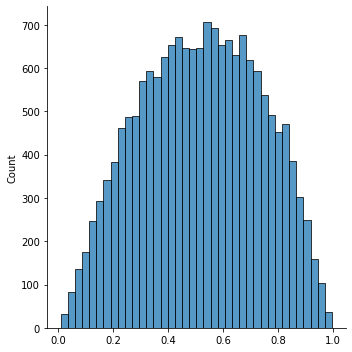

In [87]:
import seaborn as sns
p = sns.displot(pred)

In [88]:
output.to_csv('/data/MyDrive/final_statement.csv')

### Что еще попробовать?

Разумеется, можно попробовать еще очень много разных идей, которые помогут вам получить еще более высокий результат на kaggle. Вот лишь несколько возможных вариантов:
1. Про каждого из игроков есть достаточно много показателей: максимальный опыт, число смертей и т.д. (см. список выше). Можно попробовать просуммировать или усредних их, получив агрегированные показатели для всей команды.
2. В сырых данных (файл matches.jsonlines.bz2) содержится очень много информации, которую мы пока не использовали. Вы можете, например, составить "мешки слов" для покупок различных предметов (то есть кодировать информацию о том, сколько раз каждая команда покупала тот или иной предмет). Обратите внимание, что при этом вы можете получить слишком большое количество признаков, для которых может иметь смысл сделать понижение размерности с помощью метода главных компонент.
3. Можно сформировать признаки про изменения способностей героев в течение матча (ability_upgrades).
4. В этом задании используются только градиентный бустинг и логистическая регрессия — но ведь мы изучали и другие модели! Можно попробовать метод k ближайших соседей, SVM, случайный лес и так далее.

#### Сравнение XGBClassifier (с поддержкой GPU) c GradientBoostingClassifier и RandomForestClassifier

In [89]:
from xgboost import XGBClassifier

In [94]:
xgbc = XGBClassifier(tree_method='gpu_hist', gpu_id=0, learning_rate=0.3, n_estimators=200, random_state=42, 
                     eval_metric='rmse', use_label_encoder=False)
start_time = datetime.datetime.now()
sc = cross_val_score(estimator=xgbc, X=X_train_scaled, y=y_train, cv=kf, scoring='roc_auc').mean()
print("K-fold CV average score: %.3f, time elapsed: %s" % (sc, datetime.datetime.now() - start_time))

K-fold CV average score: 0.738, time elapsed: 0:02:38.116915


In [95]:
start_time = datetime.datetime.now()
clf = GradientBoostingClassifier(n_estimators=200, random_state=42, learning_rate=0.3)
sc = cross_val_score(estimator=clf, X=X_train_scaled, y=y_train, cv=kf, scoring='roc_auc').mean()   
print("K-fold CV average score: %.3f, time elapsed: %s" % (sc, datetime.datetime.now() - start_time))

K-fold CV average score: 0.738, time elapsed: 0:15:10.434680


In [96]:
start_time = datetime.datetime.now()
clf = RandomForestClassifier(random_state=42, n_estimators=200)
sc = cross_val_score(estimator=clf, X=X_train_scaled, y=y_train, cv=kf, scoring='roc_auc').mean()   
print("K-fold CV average score: %.3f, time elapsed: %s" % (sc, datetime.datetime.now() - start_time))

K-fold CV average score: 0.705, time elapsed: 0:07:47.856049


In [97]:
from sklearn.neighbors import KNeighborsClassifier
params = { 'n_neighbors': range(1, 50, 5) }
clf = KNeighborsClassifier()
gs = GridSearchCV(estimator=clf, param_grid=params, refit=True, scoring='roc_auc', n_jobs=-1, cv=kf, verbose=0)
gs.fit(X_train_scaled, y_train)
print(gs.best_params_)
print(gs.cv_results_['mean_test_score'][gs.best_index_])

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


{'n_neighbors': 46}
0.6552740378092183


Вывод - при одинаковых параметрах (n_estimators=200, learning_rate=0.3) оба Boosting-алгоритма дают одинаковый результат, но быстродействие XGBClassifier гораздо выше - 2,5 мин (или 6 мин если без GPU) против 15 мин у GradientBoostingClassifier.

Результат у случайного леса и метода ближайших соседей получился значительно ниже.

Наилучший результат дала логистическая регрессия.